In [1]:
import os
from scipy.signal import detrend
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'
import xarray as xr
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
from matplotlib import pyplot as pltt
%matplotlib inline
import numpy as np
import intake
import fsspec
import xmitgcm

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['geojson', 'postgis', 'shapefile', 'spatialite'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces1 = cat["ECCOv4r3"].to_dask()
cat = intake.Catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_faces2 = cat["ECCO_layers"].to_dask()
ds_faces=xr.merge((ds_faces1,ds_faces2))

/srv/conda/envs/notebook/lib/python3.7/site-packages/fsspec/implementations/local.py:32: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


In [3]:
import gcsfs
basins = xr.open_zarr(gcsfs.GCSFileSystem(requester_pays=True).get_mapper('pangeo-data/ECCO_basins.zarr')
                      , consolidated=True)


In [4]:
mask_2d = ds_faces['hFacC'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins.basin_mask == 2,0)+ mask_2d.where(basins.basin_mask == 7,0)
              + mask_2d.where(basins.basin_mask == 9,0)
             + mask_2d.where(basins.basin_mask == 10,0)
             + mask_2d.where(basins.basin_mask == 12,0)
             + mask_2d.where(basins.basin_mask == 18,0)
             + mask_2d.where(basins.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacC','maskC'])
ds_with_mask=xr.merge((ds_faces,basin_mask.rename('atl_maskC')))

basins2=basins.rename({'j':'j_g'})
mask_2d = ds_faces['hFacS'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins2.basin_mask == 2,0)+ mask_2d.where(basins2.basin_mask == 7,0)
              + mask_2d.where(basins2.basin_mask == 9,0)
             + mask_2d.where(basins2.basin_mask == 10,0)
             + mask_2d.where(basins2.basin_mask == 12,0)
             + mask_2d.where(basins2.basin_mask == 18,0)
             + mask_2d.where(basins2.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacS','maskS'])
ds_with_mask2=xr.merge((ds_with_mask,basin_mask.rename('atl_maskS')))

basins3=basins.rename({'i':'i_g'})
mask_2d = ds_faces['hFacW'].isel(k=0)
basin_mask = 0*mask_2d
basin_mask = (basin_mask + mask_2d.where(basins3.basin_mask == 2,0)+ mask_2d.where(basins3.basin_mask == 7,0)
              + mask_2d.where(basins3.basin_mask == 9,0)
             + mask_2d.where(basins3.basin_mask == 10,0)
             + mask_2d.where(basins3.basin_mask == 12,0)
             + mask_2d.where(basins3.basin_mask == 18,0)
             + mask_2d.where(basins3.basin_mask == 19,0))
basin_mask = (basin_mask * mask_2d).drop(['PHrefC','Z','drF','hFacW','maskW'])
ds_with_mask3=xr.merge((ds_with_mask2,basin_mask.rename('atl_maskW')))

In [5]:
ds_ll = faces_dataset_to_latlon(ds_with_mask3, metric_vector_pairs=[('LaHw3RHO','LaHs3RHO'),('atl_maskW','atl_maskS')])#.compute()
ds = (ds_ll.reset_coords(drop=True).roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))
coords = (ds_ll.coords.to_dataset().reset_coords().roll(i=180, roll_coords=False).roll(i_g=180, roll_coords=False))

In [6]:
dt = ds.time_snp[1:].load()
dt.values = [float(t)/10**9 for t in np.diff(ds.time_snp)]
dt = dt.rename({'time_snp':'time'})
dt.time.values = ds.time.values[1:-1] 
ds = ds.assign_coords(dt=dt)
ds.dt.attrs = {'units': 's','standard_name': 'dt','coordinate': 'time','long_name': 'time span between snapshots'}

In [7]:
#Interpolates longitude from j to j_g then creates array of "real" longitude over time 
from xgcm import Grid 
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
THETA_jg = grid.interp(ds.THETA, axis = 'Y')

In [9]:
#Notes: j = 259 is 65, j = 220 is 45
rho0 = 1029
latchoice = 219
cp = 3994

In [10]:
#Advection through the southern (mostly used) face at 45

advy =(ds.ADVy_TH[:,:,latchoice,136:230]*rho0*cp*ds.atl_maskS[latchoice, :]).sum(['i','k']) 
#mean = (advy * ds.dt).sum('time')/(ds.dt.sum('time'))
south_face = (advy*ds.dt).cumsum('time')

south_face.load()

<xarray.DataArray (time: 288)>
array([0.00000000e+00, 7.97275280e+20, 1.61827985e+21, 2.45121607e+21,
       3.51504811e+21, 4.71514287e+21, 5.60927824e+21, 6.57307426e+21,
       7.75210683e+21, 9.20130346e+21, 1.00298603e+22, 1.11540487e+22,
       1.21991779e+22, 1.35035841e+22, 1.47540425e+22, 1.55819817e+22,
       1.69159186e+22, 1.80115500e+22, 1.92938086e+22, 2.07293206e+22,
       2.17228292e+22, 2.33015478e+22, 2.44204733e+22, 2.54199388e+22,
       2.61023109e+22, 2.68101869e+22, 2.78032586e+22, 2.89409621e+22,
       3.00470803e+22, 3.12940234e+22, 3.23161548e+22, 3.35468864e+22,
       3.49508619e+22, 3.63214598e+22, 3.74260624e+22, 3.85269820e+22,
       3.94745282e+22, 4.02474212e+22, 4.14524337e+22, 4.28970094e+22,
       4.40826272e+22, 4.56179692e+22, 4.68862332e+22, 4.84115373e+22,
       4.97465396e+22, 5.12338346e+22, 5.28232029e+22, 5.44142081e+22,
       5.54393211e+22, 5.66778592e+22, 5.83525209e+22, 5.98585228e+22,
       6.14531039e+22, 6.27955230e+22, 6.42139678e+22, 6.56308927e+22,
       6.70160391e+22, 6.83331554e+22, 6.96205629e+22, 7.14146746e+22,
       7.31430222e+22, 7.38647785e+22, 7.52541296e+22, 7.67862624e+22,
       7.81748681e+22, 7.96360571e+22, 8.08653116e+22, 8.20933890e+22,
       8.36813804e+22, 8.53518882e+22, 8.62026547e+22, 8.75388217e+22,
       8.87545738e+22, 9.03364196e+22, 9.18481389e+22, 9.28433078e+22,
       9.43684097e+22, 9.56050381e+22, 9.68623275e+22, 9.82536136e+22,
       9.93346641e+22, 1.00684576e+23, 1.02029751e+23, 1.02773049e+23,
       1.03890541e+23, 1.05097490e+23, 1.06541526e+23, 1.07687502e+23,
       1.09083542e+23, 1.10383662e+23, 1.11623612e+23, 1.12869146e+23,
       1.13991467e+23, 1.14976124e+23, 1.16484808e+23, 1.17772406e+23,
       1.19449120e+23, 1.20450453e+23, 1.22051488e+23, 1.23362277e+23,
       1.24686755e+23, 1.25867494e+23, 1.27378842e+23, 1.28804426e+23,
       1.30088039e+23, 1.31198765e+23, 1.32504698e+23, 1.33190909e+23,
       1.34209970e+23, 1.35317287e+23, 1.36565703e+23, 1.37706019e+23,
       1.39154376e+23, 1.40489241e+23, 1.41620209e+23, 1.42968989e+23,
       1.44712435e+23, 1.45942400e+23, 1.47704496e+23, 1.49801654e+23,
       1.50745077e+23, 1.51659731e+23, 1.52822231e+23, 1.53917657e+23,
       1.54884138e+23, 1.56002056e+23, 1.57321407e+23, 1.58835200e+23,
       1.60481290e+23, 1.61952423e+23, 1.62801810e+23, 1.64197161e+23,
       1.65323748e+23, 1.66240461e+23, 1.67522979e+23, 1.68896664e+23,
       1.70088833e+23, 1.71220708e+23, 1.72499535e+23, 1.73997997e+23,
       1.75588708e+23, 1.77300122e+23, 1.78449094e+23, 1.80182658e+23,
       1.81404093e+23, 1.83032353e+23, 1.84191448e+23, 1.85439483e+23,
       1.86862301e+23, 1.88199183e+23, 1.89612536e+23, 1.90800435e+23,
       1.92177854e+23, 1.93953435e+23, 1.95638262e+23, 1.97079518e+23,
       1.98514310e+23, 2.00081276e+23, 2.01805091e+23, 2.03103801e+23,
       2.04513511e+23, 2.05801755e+23, 2.07237156e+23, 2.08693179e+23,
       2.09907545e+23, 2.11195904e+23, 2.12586599e+23, 2.14235149e+23,
       2.15470386e+23, 2.16549172e+23, 2.17875671e+23, 2.19479951e+23,
       2.20709746e+23, 2.22134713e+23, 2.23391069e+23, 2.24865695e+23,
       2.25958462e+23, 2.27415798e+23, 2.28794380e+23, 2.29702073e+23,
       2.30920732e+23, 2.31591935e+23, 2.32630772e+23, 2.33929519e+23,
       2.34935368e+23, 2.36083951e+23, 2.37115839e+23, 2.38507837e+23,
       2.40098634e+23, 2.41529940e+23, 2.43283218e+23, 2.44312693e+23,
       2.45172015e+23, 2.46517340e+23, 2.47617006e+23, 2.48881451e+23,
       2.50113981e+23, 2.51323633e+23, 2.52463349e+23, 2.53558793e+23,
       2.55133532e+23, 2.56466702e+23, 2.58020202e+23, 2.59262491e+23,
       2.59908297e+23, 2.60915791e+23, 2.62089319e+23, 2.62970240e+23,
       2.64162919e+23, 2.65496668e+23, 2.66609702e+23, 2.67721557e+23,
       2.69216933e+23, 2.70542567e+23, 2.71216292e+23, 2.72873979e+23,
       2.74247262e+23, 2.75595261e+23, 2.77172331e+23, 2.78682685e+23,
       2.79999717e+23, 2.81067860e+23, 2.82273965e+23, 2.8381533

In [11]:
#Advection through the north face at 65

advy =(ds.ADVy_TH[:,:,259,136:230]*rho0*cp*ds.atl_maskS[259, :]).sum(['i','k']) 
#mean = (advy * ds.dt).sum('time')/(ds.dt.sum('time'))
north_face = (advy*ds.dt).cumsum('time')

north_face.load()

<xarray.DataArray (time: 288)>
array([0.00000000e+00, 4.43168393e+20, 9.25934929e+20, 1.30829876e+21,
       1.74699669e+21, 2.09299788e+21, 2.49401802e+21, 2.93737865e+21,
       3.43876098e+21, 3.80797854e+21, 4.25060842e+21, 4.87529155e+21,
       5.65498771e+21, 6.13962278e+21, 6.72472692e+21, 7.15591265e+21,
       7.52719337e+21, 7.87946383e+21, 8.27685610e+21, 8.66219233e+21,
       9.00724895e+21, 9.30574269e+21, 9.70457313e+21, 1.02277978e+22,
       1.06405897e+22, 1.10253889e+22, 1.15646534e+22, 1.20222097e+22,
       1.23721338e+22, 1.27628268e+22, 1.30992766e+22, 1.34436935e+22,
       1.38403834e+22, 1.42394745e+22, 1.46566738e+22, 1.52215105e+22,
       1.57642350e+22, 1.63144444e+22, 1.69110371e+22, 1.73349481e+22,
       1.76776725e+22, 1.79810920e+22, 1.83234171e+22, 1.86329452e+22,
       1.89382267e+22, 1.93625640e+22, 1.97676316e+22, 2.01365274e+22,
       2.04931966e+22, 2.07812463e+22, 2.11305915e+22, 2.14462911e+22,
       2.17287527e+22, 2.21101453e+22, 2.24626909e+22, 2.27832113e+22,
       2.31098386e+22, 2.34732947e+22, 2.39436540e+22, 2.43748482e+22,
       2.47511841e+22, 2.51832874e+22, 2.56696810e+22, 2.60632215e+22,
       2.64066879e+22, 2.66910423e+22, 2.70056446e+22, 2.73123915e+22,
       2.77211877e+22, 2.81261494e+22, 2.85123035e+22, 2.90226361e+22,
       2.94691969e+22, 2.98693528e+22, 3.03502687e+22, 3.07127406e+22,
       3.10742793e+22, 3.13710884e+22, 3.17182663e+22, 3.20793640e+22,
       3.24437596e+22, 3.28518920e+22, 3.32752488e+22, 3.37673161e+22,
       3.42930322e+22, 3.47513818e+22, 3.52444666e+22, 3.56972890e+22,
       3.60521668e+22, 3.63713614e+22, 3.66885411e+22, 3.69825167e+22,
       3.73528017e+22, 3.77808267e+22, 3.82934953e+22, 3.87052109e+22,
       3.92410756e+22, 3.96929210e+22, 4.01212020e+22, 4.05395474e+22,
       4.09088760e+22, 4.12904303e+22, 4.15844265e+22, 4.19329099e+22,
       4.23660620e+22, 4.28704139e+22, 4.33095302e+22, 4.37480194e+22,
       4.42256906e+22, 4.45613757e+22, 4.49600904e+22, 4.53424042e+22,
       4.57176392e+22, 4.60643209e+22, 4.64044987e+22, 4.68146717e+22,
       4.71953282e+22, 4.76555537e+22, 4.80467869e+22, 4.85141486e+22,
       4.90263502e+22, 4.94149477e+22, 4.98182969e+22, 5.02504002e+22,
       5.07118078e+22, 5.11947222e+22, 5.16234353e+22, 5.20635001e+22,
       5.25109405e+22, 5.30358477e+22, 5.34522991e+22, 5.38320409e+22,
       5.42450039e+22, 5.46434439e+22, 5.50421470e+22, 5.54142668e+22,
       5.57970072e+22, 5.61553209e+22, 5.65509819e+22, 5.69226172e+22,
       5.73036273e+22, 5.77358561e+22, 5.81693367e+22, 5.85534344e+22,
       5.89969220e+22, 5.94277829e+22, 5.98698703e+22, 6.02119850e+22,
       6.06171824e+22, 6.09700562e+22, 6.13296149e+22, 6.16139550e+22,
       6.19551100e+22, 6.22895816e+22, 6.26280822e+22, 6.30950229e+22,
       6.35810695e+22, 6.39731401e+22, 6.43913247e+22, 6.48167430e+22,
       6.52362802e+22, 6.55732745e+22, 6.58801021e+22, 6.62429712e+22,
       6.66366188e+22, 6.71018245e+22, 6.76056851e+22, 6.80532535e+22,
       6.86165899e+22, 6.89902542e+22, 6.94384431e+22, 6.98968791e+22,
       7.03152384e+22, 7.07286599e+22, 7.11004795e+22, 7.14675956e+22,
       7.18764050e+22, 7.22019721e+22, 7.27099060e+22, 7.32095828e+22,
       7.37162736e+22, 7.41010137e+22, 7.45817399e+22, 7.50003981e+22,
       7.54831717e+22, 7.58552363e+22, 7.62296236e+22, 7.66250578e+22,
       7.69731072e+22, 7.73329493e+22, 7.77066302e+22, 7.81711703e+22,
       7.86377820e+22, 7.91638742e+22, 7.96642754e+22, 8.00723276e+22,
       8.04848255e+22, 8.08743292e+22, 8.12120599e+22, 8.15356455e+22,
       8.18562613e+22, 8.24504427e+22, 8.28577631e+22, 8.33453128e+22,
       8.38561693e+22, 8.42788587e+22, 8.47826461e+22, 8.52526800e+22,
       8.57842318e+22, 8.61992377e+22, 8.65459268e+22, 8.69891086e+22,
       8.74640823e+22, 8.79101660e+22, 8.84570055e+22, 8.89968442e+22,
       8.94226435e+22, 8.97760434e+22, 9.01418065e+22, 9.05461744e+22,
       9.08936732e+22, 9.11757923e+22, 9.15346790e+22, 9.1883417

In [ ]:
#surface 
advy = (ds.VVELMASS[:, 0, 220:259] * THETA_jg[:, 0, 220:259, ] * coords.dxG[220:259, :] * coords.dyC[220:259, :]*
ds.atl_maskS[220:259, :])
f =(advy[:,:,136:230]*rho0*cp).sum(['i','j_g'])
mean_face =(f*ds.dt).sum('time')/(ds.dt.sum('time')) 
surface = ((f-mean_face)*ds.dt).cumsum('time')
surface.load()

In [12]:
#Forcing term  
grid = Grid(ds, coords={'Y':{'center':'j', 'left':'j_g'}})
TFLUX_jg = grid.interp(ds.TFLUX*coords.hFacC.isel(k=0), axis = 'Y')
surface_t = TFLUX_jg[:, latchoice:259, 136:230] * coords.rAs[latchoice:259, 136:230] * ds.atl_maskS[latchoice:259, 136:230] * ds.dt 
surface = (surface_t.sum(['i','j_g'])).cumsum('time')
surface.load()

<xarray.DataArray (time: 288)>
array([ 0.00000000e+00, -4.61980284e+21, -6.85435042e+21, -6.81668380e+21,
       -4.35295862e+21, -1.00992782e+21,  1.83757676e+21,  3.25257150e+21,
        2.96553483e+21,  8.69294033e+20, -3.62383351e+21, -8.88955361e+21,
       -1.48111968e+22, -1.75986325e+22, -2.03171820e+22, -1.98376379e+22,
       -1.76066186e+22, -1.45163352e+22, -1.12213923e+22, -9.20767821e+21,
       -9.58981150e+21, -1.22439918e+22, -1.70804565e+22, -2.19271841e+22,
       -2.74971310e+22, -3.17973740e+22, -3.41438391e+22, -3.39877003e+22,
       -3.12168848e+22, -2.79656955e+22, -2.44851057e+22, -2.24048680e+22,
       -2.27571368e+22, -2.46527100e+22, -2.80483256e+22, -3.33382938e+22,
       -3.83563323e+22, -4.23031054e+22, -4.48771506e+22, -4.39412331e+22,
       -4.12576205e+22, -3.76696935e+22, -3.45102719e+22, -3.24158282e+22,
       -3.29171706e+22, -3.55188616e+22, -3.88642604e+22, -4.31802696e+22,
       -4.79571804e+22, -5.11330018e+22, -5.26585432e+22, -5.15456412e+22,
       -4.94170975e+22, -4.62648134e+22, -4.26789134e+22, -4.06756604e+22,
       -4.11770365e+22, -4.38875872e+22, -4.79345228e+22, -5.24190596e+22,
       -5.66174710e+22, -6.15948640e+22, -6.40433860e+22, -6.29683361e+22,
       -6.05749402e+22, -5.74681526e+22, -5.38653313e+22, -5.19316837e+22,
       -5.22249377e+22, -5.41868074e+22, -5.83360106e+22, -6.24224732e+22,
       -6.75655582e+22, -7.08956866e+22, -7.29179348e+22, -7.26265695e+22,
       -6.98654459e+22, -6.66325095e+22, -6.31954400e+22, -6.11657667e+22,
       -6.14724512e+22, -6.44442282e+22, -6.85136401e+22, -7.40667459e+22,
       -7.93549467e+22, -8.22896832e+22, -8.38143903e+22, -8.30130137e+22,
       -8.05480536e+22, -7.72159258e+22, -7.37979336e+22, -7.18627210e+22,
       -7.24743236e+22, -7.55970758e+22, -7.92679334e+22, -8.44906904e+22,
       -8.90114544e+22, -9.35294557e+22, -9.48208479e+22, -9.48337258e+22,
       -9.22671660e+22, -8.91527759e+22, -8.55251249e+22, -8.34184578e+22,
       -8.39942005e+22, -8.73102449e+22, -9.09373749e+22, -9.60280325e+22,
       -1.00669046e+23, -1.04387677e+23, -1.06184700e+23, -1.05604870e+23,
       -1.02811869e+23, -9.94457118e+22, -9.61152667e+22, -9.41334944e+22,
       -9.43257140e+22, -9.66121397e+22, -1.00523776e+23, -1.04513514e+23,
       -1.09458004e+23, -1.13823337e+23, -1.16571567e+23, -1.16418970e+23,
       -1.14182363e+23, -1.11037098e+23, -1.07364513e+23, -1.05155673e+23,
       -1.05291870e+23, -1.08509328e+23, -1.12464672e+23, -1.16075499e+23,
       -1.20443533e+23, -1.24406091e+23, -1.26441467e+23, -1.25993157e+23,
       -1.23661734e+23, -1.20444401e+23, -1.16882210e+23, -1.14736217e+23,
       -1.14910924e+23, -1.17307966e+23, -1.21389370e+23, -1.25201711e+23,
       -1.29840751e+23, -1.32942953e+23, -1.35102325e+23, -1.34393495e+23,
       -1.32087084e+23, -1.28885129e+23, -1.25439268e+23, -1.23384289e+23,
       -1.23840562e+23, -1.26527236e+23, -1.29648060e+23, -1.34665119e+23,
       -1.39933014e+23, -1.42645203e+23, -1.43806599e+23, -1.43325599e+23,
       -1.40939743e+23, -1.37640764e+23, -1.33980474e+23, -1.32194047e+23,
       -1.32826497e+23, -1.35699644e+23, -1.39799493e+23, -1.43951714e+23,
       -1.48475736e+23, -1.51689100e+23, -1.53528001e+23, -1.52738053e+23,
       -1.50457703e+23, -1.46855363e+23, -1.43168694e+23, -1.41368652e+23,
       -1.41755222e+23, -1.44238632e+23, -1.48839499e+23, -1.53906684e+23,
       -1.58615069e+23, -1.62206329e+23, -1.64534288e+23, -1.63535977e+23,
       -1.61576843e+23, -1.58221320e+23, -1.54801344e+23, -1.52756749e+23,
       -1.53273949e+23, -1.55273854e+23, -1.58648987e+23, -1.64326546e+23,
       -1.69802209e+23, -1.73671394e+23, -1.76228732e+23, -1.75699161e+23,
       -1.72731880e+23, -1.69577617e+23, -1.66038838e+23, -1.64208470e+23,
       -1.64866543e+23, -1.67938875e+23, -1.71415307e+23, -1.76394022e+23,
       -1.81694534e+23, -1.84315980e+23, -1.86315335e+23, -1.85665018e+23,
       -1.83551323e+23, -1.80100782e+23, -1.77035509e+23, -1.75195885

In [15]:
#Left side term 
hc = (ds.THETA_snp* coords.rA * (coords.drF*(1+ds.ETAN_snp/coords.Depth))* coords.hFacC)[:, :, latchoice:259, 136:230]
summed = hc.sum(['i','j','k'])
net_hc = ((summed - summed.isel(time_snp=0))*1029*3994*1e-22).load()

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*args2)


In [ ]:
net_hc.plot()

In [16]:
#Diffusive term
south =(ds.DFyE_TH[:,:,latchoice,136:230]*rho0*cp).sum(['i','k']) 
north =(ds.DFyE_TH[:,:,259,136:230]*rho0*cp).sum(['i','k']) 

diffusive_net = ((south-north)*ds.dt).cumsum('time').load()

In [17]:
#Detrending and mean-removing 
north_detrend = xr.apply_ufunc(detrend, north_face.fillna(0),kwargs={'axis': 0}).where(~north_face.isnull())
south_detrend = xr.apply_ufunc(detrend, south_face.fillna(0),kwargs={'axis': 0}).where(~south_face.isnull())
sur_detrend = xr.apply_ufunc(detrend, surface.fillna(0),kwargs={'axis': 0}).where(~surface.isnull())
net_detrend = xr.apply_ufunc(detrend, net_hc.fillna(0),kwargs={'axis': 0}).where(~net_hc.isnull())
diff_detrend = xr.apply_ufunc(detrend, diffusive_net.fillna(0),kwargs={'axis': 0}).where(~diffusive_net.isnull())

n = north_detrend.groupby('time.month').mean('time')
s = south_detrend.groupby('time.month').mean('time')
r = sur_detrend.groupby('time.month').mean('time')
h = net_detrend.groupby('time_snp.month').mean('time_snp')
d = diff_detrend.groupby('time.month').mean('time')

north_final = north_detrend.groupby('time.month') - n
surface_final = sur_detrend.groupby('time.month') - r
south_final = south_detrend.groupby('time.month') - s
net_final = net_detrend.groupby('time_snp.month') - h
diff_final = diff_detrend.groupby('time.month') - d

In [18]:
net_final = net_final.rename({'time_snp' : 'time'})
net_final['time'] = south_final.time[:-1]

/srv/conda/envs/notebook/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Heat Content (J)')

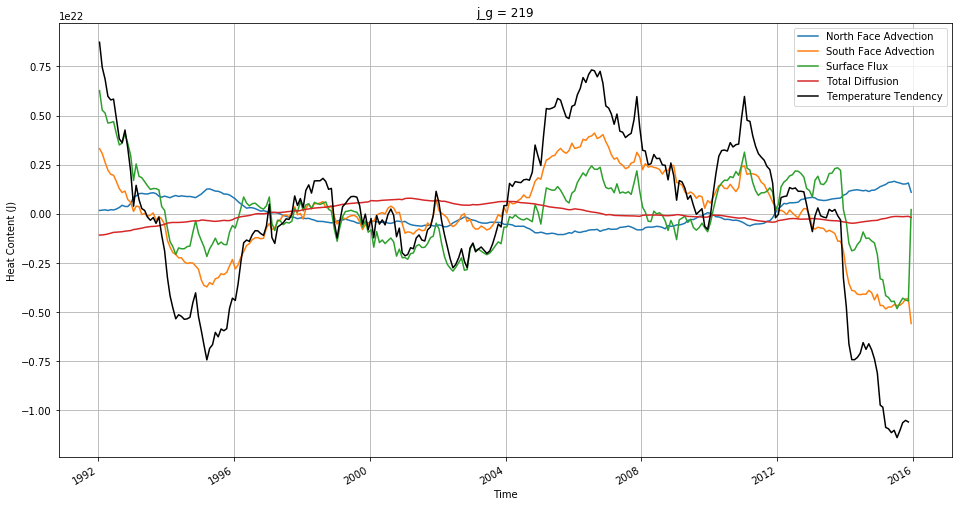

In [19]:
fig, ax = pltt.subplots(figsize = (16,8))
(north_final).plot()
(south_final).plot()
(surface_final).plot()
(diff_final).plot()
(net_final*1e22).plot(color = 'k')
#( south_final + surface_final + diff_final - north_final - net_final*1e22).plot()
# pltt.legend(("Northern face","Southern face","Surface", "LHS", "diff", "Sum"), loc="upper left")
pltt.legend(('North Face Advection','South Face Advection','Surface Flux','Total Diffusion','Temperature Tendency' ))
pltt.grid()
pltt.ylabel('Heat Content (J)')

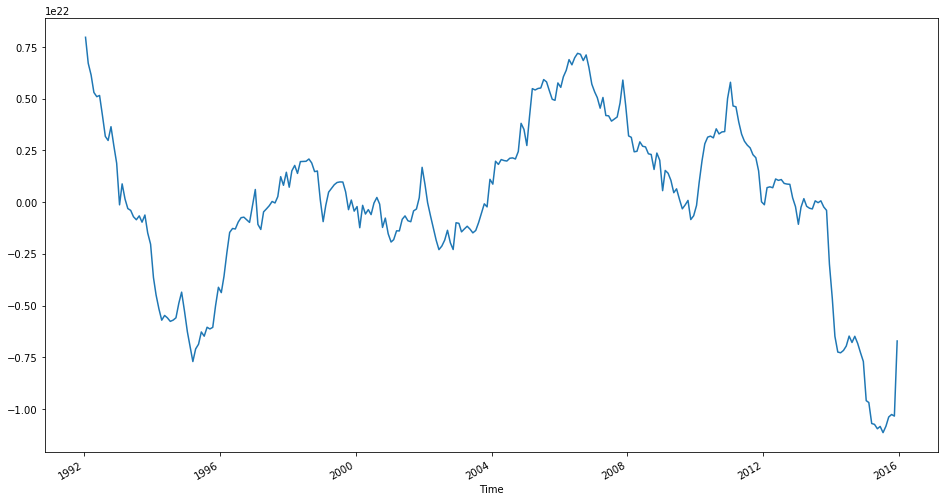

In [75]:
(south_final - north_final + surface_final + diff_final).plot(figsize=(16,8))

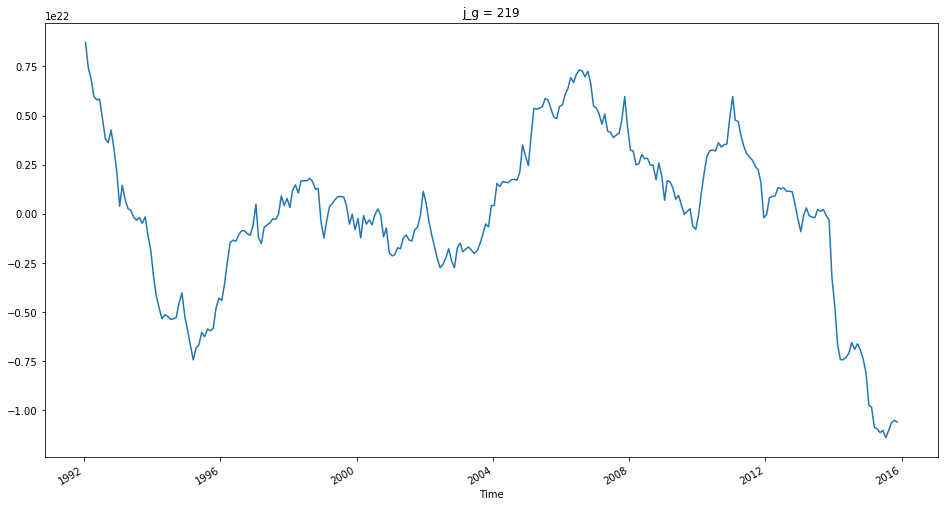

In [20]:
(net_final*1e22).plot(figsize=(16,8))

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Legend does not support 's' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  import sys
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Legend does not support '+' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  import sys
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Legend does not support 'n' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  import sys


Text(0, 0.5, 'Heat Content (J)')

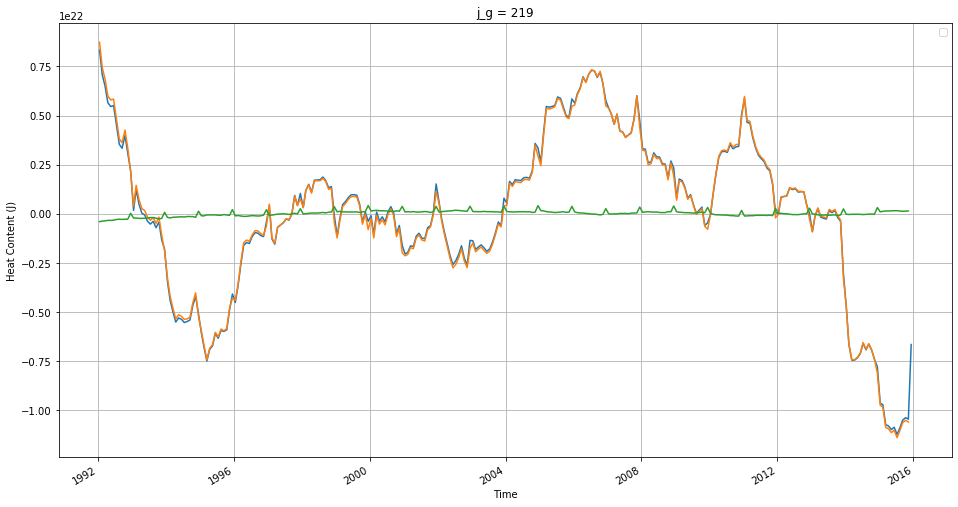

In [21]:
fig, ax = pltt.subplots(figsize = (16,8))
(south_final - north_final + surface_final + diff_final).plot()
(net_final*1e22).plot()
(south_final - north_final + surface_final + diff_final - net_final*1e22).plot()
#( south_final + surface_final + diff_final - north_final - net_final*1e22).plot()
# pltt.legend(("Northern face","Southern face","Surface", "LHS", "diff", "Sum"), loc="upper left")
pltt.legend('s+n+f+d', 'net')
pltt.grid()
pltt.ylabel('Heat Content (J)')